In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import fsspec, os
import scipy as sp
import PIL
from PIL import Image
import random
import glob
import re

In [3]:
state = 3  # state 1 -> javier, state 2 -> william, state 3 -> combined
if state == 1:
    shot_list = [119591, 119599, 119601, 119646, 119648, 119653, 119654, 119658, 119659,
             119661, 119662, 119663, 119665, 119666, 119667, 119669, 119670, 119671,
             119673, 119675, 119748, 119750, 119751, 119752, 119754, 119755, 119756,
             119757, 119760, 119761, 119762, 119763, 119764, 119766, 119767, 119768, 119769]
    file_path = '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/Input Data/Shots/' 
    file_path_hbt = '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/python_hbteplib_data/'
elif state == 2:
    shot_list = [114407,114408,114411,114412,114413,114415,114416,114417,114418,114419,114420,114422,114424,114425,114428,114429,114431,114432,114433,
                 114434,114435,114436,114438,114439,114441,114443,114444,114445,114448,114450,114451,114453,114454,114455,114456,114457,114458,114460,
                 114462,114464,114467,114468,114472,114473]
    file_path = '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/Input Data/Old Shots/' 
    file_path_hbt = '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/oldshot_python_hbteplib_data/' 
elif state == 3:
    shot_list = [119591, 119599, 119601, 119646, 119648, 119653, 119654, 119658, 119659,
             119661, 119662, 119663, 119665, 119666, 119667, 119669, 119670, 119671,
             119673, 119675, 119748, 119750, 119751, 119752, 119754, 119755, 119756,
             119757, 119760, 119761, 119762, 119763, 119764, 119766, 119767, 119768, 119769,
             114407,114408,114411,114412,114413,114415,114416,114417,114418,114419,114420,114422,114424,114425,114428,114429,114431,114432,114433,
             114434,114435,114436,114438,114439,114441,114443,114444,114445,114448,114450,114451,114453,114454,114455,114456,114457,114458,114460,
             114462,114464,114467,114468,114472,114473]
    # For shots in range 119591-119769, use Javier's paths
    # For shots in range 114407-114473, use William's paths
    def get_paths_for_shot(shot_num):
        #print(f"Processing shot: {shot_num}")
        if 119591 <= shot_num <= 119769:
            return (
                '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/Input Data/Shots/',
                '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/python_hbteplib_data/',
                '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/ip_Data/'
            )
        elif 114407 <= shot_num <= 114473:
            return (
                '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/Input Data/Old Shots/',
                '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/oldshot_python_hbteplib_data/',
                '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/oldshot_python_hbteplib_data/'
            )
        else:
            raise ValueError(f"Shot number {shot_num} is not in the defined ranges.")

CAMERA_DEPTH = 65535.0 # 2^16
DEFAULT_FRAME_COUNT = 800

In [4]:
def load_ip_data(shot_list, state):
    ip_data = []
    for shot in shot_list:
        if state == 3:
            file_path, file_path_hbt, file_path_ip = get_paths_for_shot(shot)
        elif state == 1:
            file_path_ip = '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/ip_Data'
        elif state == 2:
            file_path_ip = '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/oldshot_python_hbteplib_data'
        else:
            raise ValueError(f"Invalid state: {state}")
        try:
            shot_data = np.load(os.path.join(file_path_ip, f'{shot}ip.npy'))
            ip_data.append(shot_data)
        except FileNotFoundError:
            print(f"IP data file for shot {shot} not found. Skipping.")
            continue
    return ip_data

def format_ip_data(data, target_length=DEFAULT_FRAME_COUNT):
    data = np.asarray(data, dtype=float)
    frame_ratio = data[0].shape[0] // target_length
    data = np.reshape(data, (len(data), -1, 1))
    data = data[:,::frame_ratio,:]
    data = data[:,:target_length,:]
    return data

def find_initial_cutoff_index(ip_data, window_size=5, start_index=50):
    smoothed_ip = np.convolve(ip_data, np.ones(window_size)/window_size, mode='valid')
    pad = window_size // 2
    smoothed_ip = np.pad(smoothed_ip, (pad, pad), mode='edge')
    if len(smoothed_ip) > len(ip_data):
        smoothed_ip = smoothed_ip[:len(ip_data)]
    
    diff = np.diff(smoothed_ip)
    
    peak_index = None
    for i in range(50, len(diff)):
        if diff[i-1] > 0 and diff[i] < 0 and ip_data[i] > 0:
            peak_index = i
            break
    if peak_index is None:
        return 0
    
    valley_index = None
    for i in range(peak_index + 1, len(diff)):
        if diff[i-1] < 0 and diff[i] > 0 and ip_data[i] > 0:
            valley_index = i
            break
    if valley_index is None:
        return peak_index
    
    return valley_index

def find_end_cutoff_index(ip_data, window_size=5, jump_ratio=2.5, lookback_window=10, stability_window=30):
    smoothed_ip = np.convolve(ip_data, np.ones(window_size)/window_size, mode='valid')
    pad = window_size // 2
    smoothed_ip = np.pad(smoothed_ip, (pad, pad), mode='edge')
    if len(smoothed_ip) > len(ip_data):
        smoothed_ip = smoothed_ip[:len(ip_data)]
    
    diff = np.diff(smoothed_ip)
    
    if len(diff) > stability_window:
        baseline_median = np.median(diff[:stability_window])
    else:
        baseline_median = np.median(diff) if len(diff) > 0 else 0.0
    
    for i in range(stability_window, len(diff) - lookback_window):
        max_deriv = np.max(diff[i:i + lookback_window])
        if max_deriv > jump_ratio * abs(baseline_median) and diff[i] < max_deriv * 0.2:
            return max(0, i - window_size)
    for i in range(stability_window, len(diff)):
        if diff[i] < -jump_ratio * abs(baseline_median):
            return max(0, i - window_size)
    return len(ip_data)

# Calculate cutoff indices and frame counts
ip_data = load_ip_data(shot_list, state)
formatted_ip_data = format_ip_data(ip_data)

initial_cutoff_indices = []
end_cutoff_indices = []
frame_counts = []
for i in range(len(shot_list)):
    ip = formatted_ip_data[i, :, 0]
    initial_cutoff_index = find_initial_cutoff_index(ip, window_size=5, start_index=50)
    initial_cutoff_indices.append(initial_cutoff_index)
    
    start_cutoff = initial_cutoff_indices[i]
    truncated_ip = formatted_ip_data[i, start_cutoff:, 0]
    end_cutoff = find_end_cutoff_index(truncated_ip)
    end_cutoff_index = end_cutoff + start_cutoff if end_cutoff < len(truncated_ip) else DEFAULT_FRAME_COUNT
    end_cutoff_indices.append(end_cutoff_index)
    
    frame_count = end_cutoff_index - initial_cutoff_index
    frame_counts.append(frame_count)

In [5]:
# Helper functions for data processing
def process_shot_data(folder_path, initial_cutoff, end_cutoff, max_pixel_value=CAMERA_DEPTH):
    tiff_files = sorted(glob.glob(os.path.join(folder_path, "*.tiff")))
    num_frames = len(tiff_files)
    
    if num_frames == 0:
        raise ValueError(f"No TIFF files found in {folder_path}")
    
    if end_cutoff is None or end_cutoff > num_frames:
        end_cutoff = num_frames
    if initial_cutoff >= end_cutoff:
        raise ValueError(f"Invalid cutoff indices: initial={initial_cutoff}, end={end_cutoff}")
    
    shot_2d = []
    cut_shot = []
    flat_shot = []
    
    for tiff_file in tiff_files[initial_cutoff:end_cutoff]: # only take the good frames!
        try:
            im = Image.open(tiff_file)
            im = np.array(im, dtype=np.float32)
            im = im / max_pixel_value
            
            # Automatically crop the center 32x32 region of the image
            h, w = im.shape
            if h < 32 or w < 32:
                raise ValueError(f"Image too small to crop to 32x32: got {h}x{w}")

            start_h = (h - 32) // 2
            start_w = (w - 32) // 2
            cropped_im = im[start_h:start_h + 32, start_w:start_w + 32]

            
            flat_im = cropped_im.reshape(-1)  # Flatten the cropped image (32*32 = 1024)
            cut_2d = cropped_im  # cut_2d is the same as cropped_im (32x32)
            
            shot_2d.append(cropped_im)  # Store cropped image (32x32)
            flat_shot.append(flat_im)
            cut_shot.append(cut_2d)
            
        except Exception as e:
            print(f"Error loading {tiff_file}: {e}")
            continue
    
    if len(shot_2d) == 0:
        raise ValueError(f"No valid frames processed for {folder_path}")
    
    actual_frames = len(shot_2d)
    return np.array(shot_2d), np.array(cut_shot), np.array(flat_shot), actual_frames

def process_all_shots(shot_list, base_path, initial_cutoff_indices, end_cutoff_indices, frame_counts):
    training_data_2D = []
    cut_training_data_2D = []
    flat_training_data = []
    valid_shots = []
    actual_frame_counts = []
    
    for i, shot in enumerate(shot_list):
        if state == 3:
            file_path, _,_ = get_paths_for_shot(shot)
            folder_path = os.path.join(file_path, str(shot), 'CAM-26731/tiff/')
        else:
            folder_path = os.path.join(base_path, str(shot), 'CAM-26731/tiff/')
        initial_cutoff = initial_cutoff_indices[i]
        end_cutoff = end_cutoff_indices[i]
        
        try:
            shot_2d, cut_2d, flat_data, actual_frames = process_shot_data(
                folder_path, 
                initial_cutoff=initial_cutoff, 
                end_cutoff=end_cutoff
            )
            
            if actual_frames > 0:
                training_data_2D.append(shot_2d)
                cut_training_data_2D.append(cut_2d)
                flat_training_data.append(flat_data)
                valid_shots.append(shot)
                actual_frame_counts.append(actual_frames)
                #print(f"Shot {shot}: {actual_frames} frames processed (expected {frame_counts[i]})")
            else:
                print(f"Shot {shot} produced 0 frames. Skipping.")
                
        except Exception as e:
            print(f"Error processing shot {shot}: {e}")
            continue
    
    return (training_data_2D, 
            cut_training_data_2D, 
            flat_training_data, 
            valid_shots, 
            actual_frame_counts)

if state == 3:
    file_path = 'blank'
# Process shots with trimmed frames
training_data_2D, cut_training_data_2D, flat_training_data, valid_shots, actual_frame_counts = process_all_shots(
    shot_list, file_path, initial_cutoff_indices, end_cutoff_indices, frame_counts
)

# Format HBT data (modified to use actual_frame_counts)
def format_hbt_data(data, mode_num, initial_cutoffs, end_cutoffs):
    formatted_data = []
    for i, shot in enumerate(valid_shots):
        shot_idx = shot_list.index(shot)
        initial_cutoff = initial_cutoffs[shot_idx]
        end_cutoff = end_cutoffs[shot_idx]
        shot_data = data[shot_idx]
        mode_data = shot_data[mode_num-1][initial_cutoff:end_cutoff]
        formatted_data.append(mode_data.reshape(-1, 1))
    return formatted_data

In [6]:
hbt_ma_data = []
hbt_mp_data = []
hbt_time_data = []
for i in range(len(shot_list)):
    ma_list = []
    mp_list = []
    if state == 3:
        _, file_path_hbt,_ = get_paths_for_shot(shot_list[i])
    
    for j in range(1,5):
        ma_data = np.load(file_path_hbt+str(shot_list[i])+'m'+str(j)+'Amp.npy')
        mp_data = np.load(file_path_hbt+str(shot_list[i])+'m'+str(j)+'Phase.npy')
        ma_list.append(ma_data)
        mp_list.append(mp_data)
    
    hbt_ma_data.append(ma_list)
    hbt_mp_data.append(mp_list)
    time_data = np.load(file_path_hbt+str(shot_list[i])+'time.npy')
    hbt_time_data.append(time_data)

hbt_ma1_data = format_hbt_data(hbt_ma_data, 1, initial_cutoff_indices, end_cutoff_indices)
hbt_ma2_data = format_hbt_data(hbt_ma_data, 2, initial_cutoff_indices, end_cutoff_indices)
hbt_ma3_data = format_hbt_data(hbt_ma_data, 3, initial_cutoff_indices, end_cutoff_indices)
hbt_ma4_data = format_hbt_data(hbt_ma_data, 4, initial_cutoff_indices, end_cutoff_indices)

hbt_mp1_data = format_hbt_data(hbt_mp_data, 1, initial_cutoff_indices, end_cutoff_indices)
hbt_mp2_data = format_hbt_data(hbt_mp_data, 2, initial_cutoff_indices, end_cutoff_indices)
hbt_mp3_data = format_hbt_data(hbt_mp_data, 3, initial_cutoff_indices, end_cutoff_indices)
hbt_mp4_data = format_hbt_data(hbt_mp_data, 4, initial_cutoff_indices, end_cutoff_indices)

formatted_time_data = []
for i, shot in enumerate(valid_shots):
    shot_idx = shot_list.index(shot)
    initial_cutoff = initial_cutoff_indices[shot_idx]
    end_cutoff = end_cutoff_indices[shot_idx]
    formatted_time = hbt_time_data[shot_idx][initial_cutoff:end_cutoff]
    formatted_time_data.append(formatted_time)
hbt_time_data = formatted_time_data

print("HBT data shapes:")
print(f"Mode amplitude 1: {len(hbt_ma1_data)} shots with variable frame counts")
print(f"Mode phase 1: {len(hbt_mp1_data)} shots with variable frame counts")
print(f"Time data: {len(hbt_time_data)} shots with variable frame counts")


HBT data shapes:
Mode amplitude 1: 81 shots with variable frame counts
Mode phase 1: 81 shots with variable frame counts
Time data: 81 shots with variable frame counts


Training shape: (42593, 32, 32, 1) Target shape: (42593, 1)
Testing shape: (400, 32, 32, 1) Testing label shape: (400, 1)


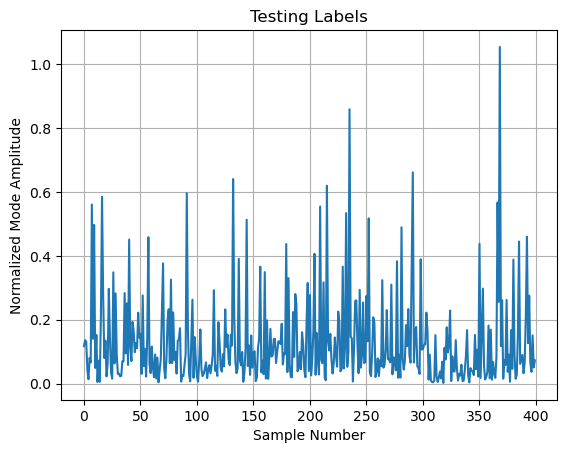

In [7]:
# Prepare data for HBT prediction model
target_data = hbt_ma2_data  # Using mode 2 amplitude as target
training_data = cut_training_data_2D

# Normalization factors
camera_norm = 1  # Camera data already normalized by max_pixel_value
ma_norm = 5
#ma_norm = np.max([np.max(np.abs(shot)) for shot in target_data if len(shot) > 0])  # Dynamic HBT normalization

# Reshape the training data and labels
target_vector = []
training_vector = []
for i, shot in enumerate(valid_shots):
    shot_idx = shot_list.index(shot)
    for j in range(actual_frame_counts[i]):
        target_vector.append(target_data[shot_idx][j])
        training_vector.append(training_data[i][j])

# Shuffle the data
random.seed(123)
zip_list = list(zip(target_vector, training_vector))
random.shuffle(zip_list)
target_vector, training_vector = zip(*zip_list)

# Convert to numpy arrays and normalize
target_vector = np.asarray(target_vector, dtype=np.float32) / ma_norm
training_vector = np.asarray(training_vector, dtype=np.float32).reshape(-1, 32, 32, 1)

# Split into training and testing sets
test_size = 400
testing_inputs = training_vector[-test_size:]
testing_labels = target_vector[-test_size:]
training_vector = training_vector[:-test_size]
target_vector = target_vector[:-test_size]

print('Training shape:', training_vector.shape, 'Target shape:', target_vector.shape)
print('Testing shape:', testing_inputs.shape, 'Testing label shape:', testing_labels.shape)

# Plot testing labels
plt.plot(testing_labels)
plt.xlabel('Sample Number')
plt.ylabel('Normalized Mode Amplitude')
plt.title('Testing Labels')
plt.grid(True)
plt.show()

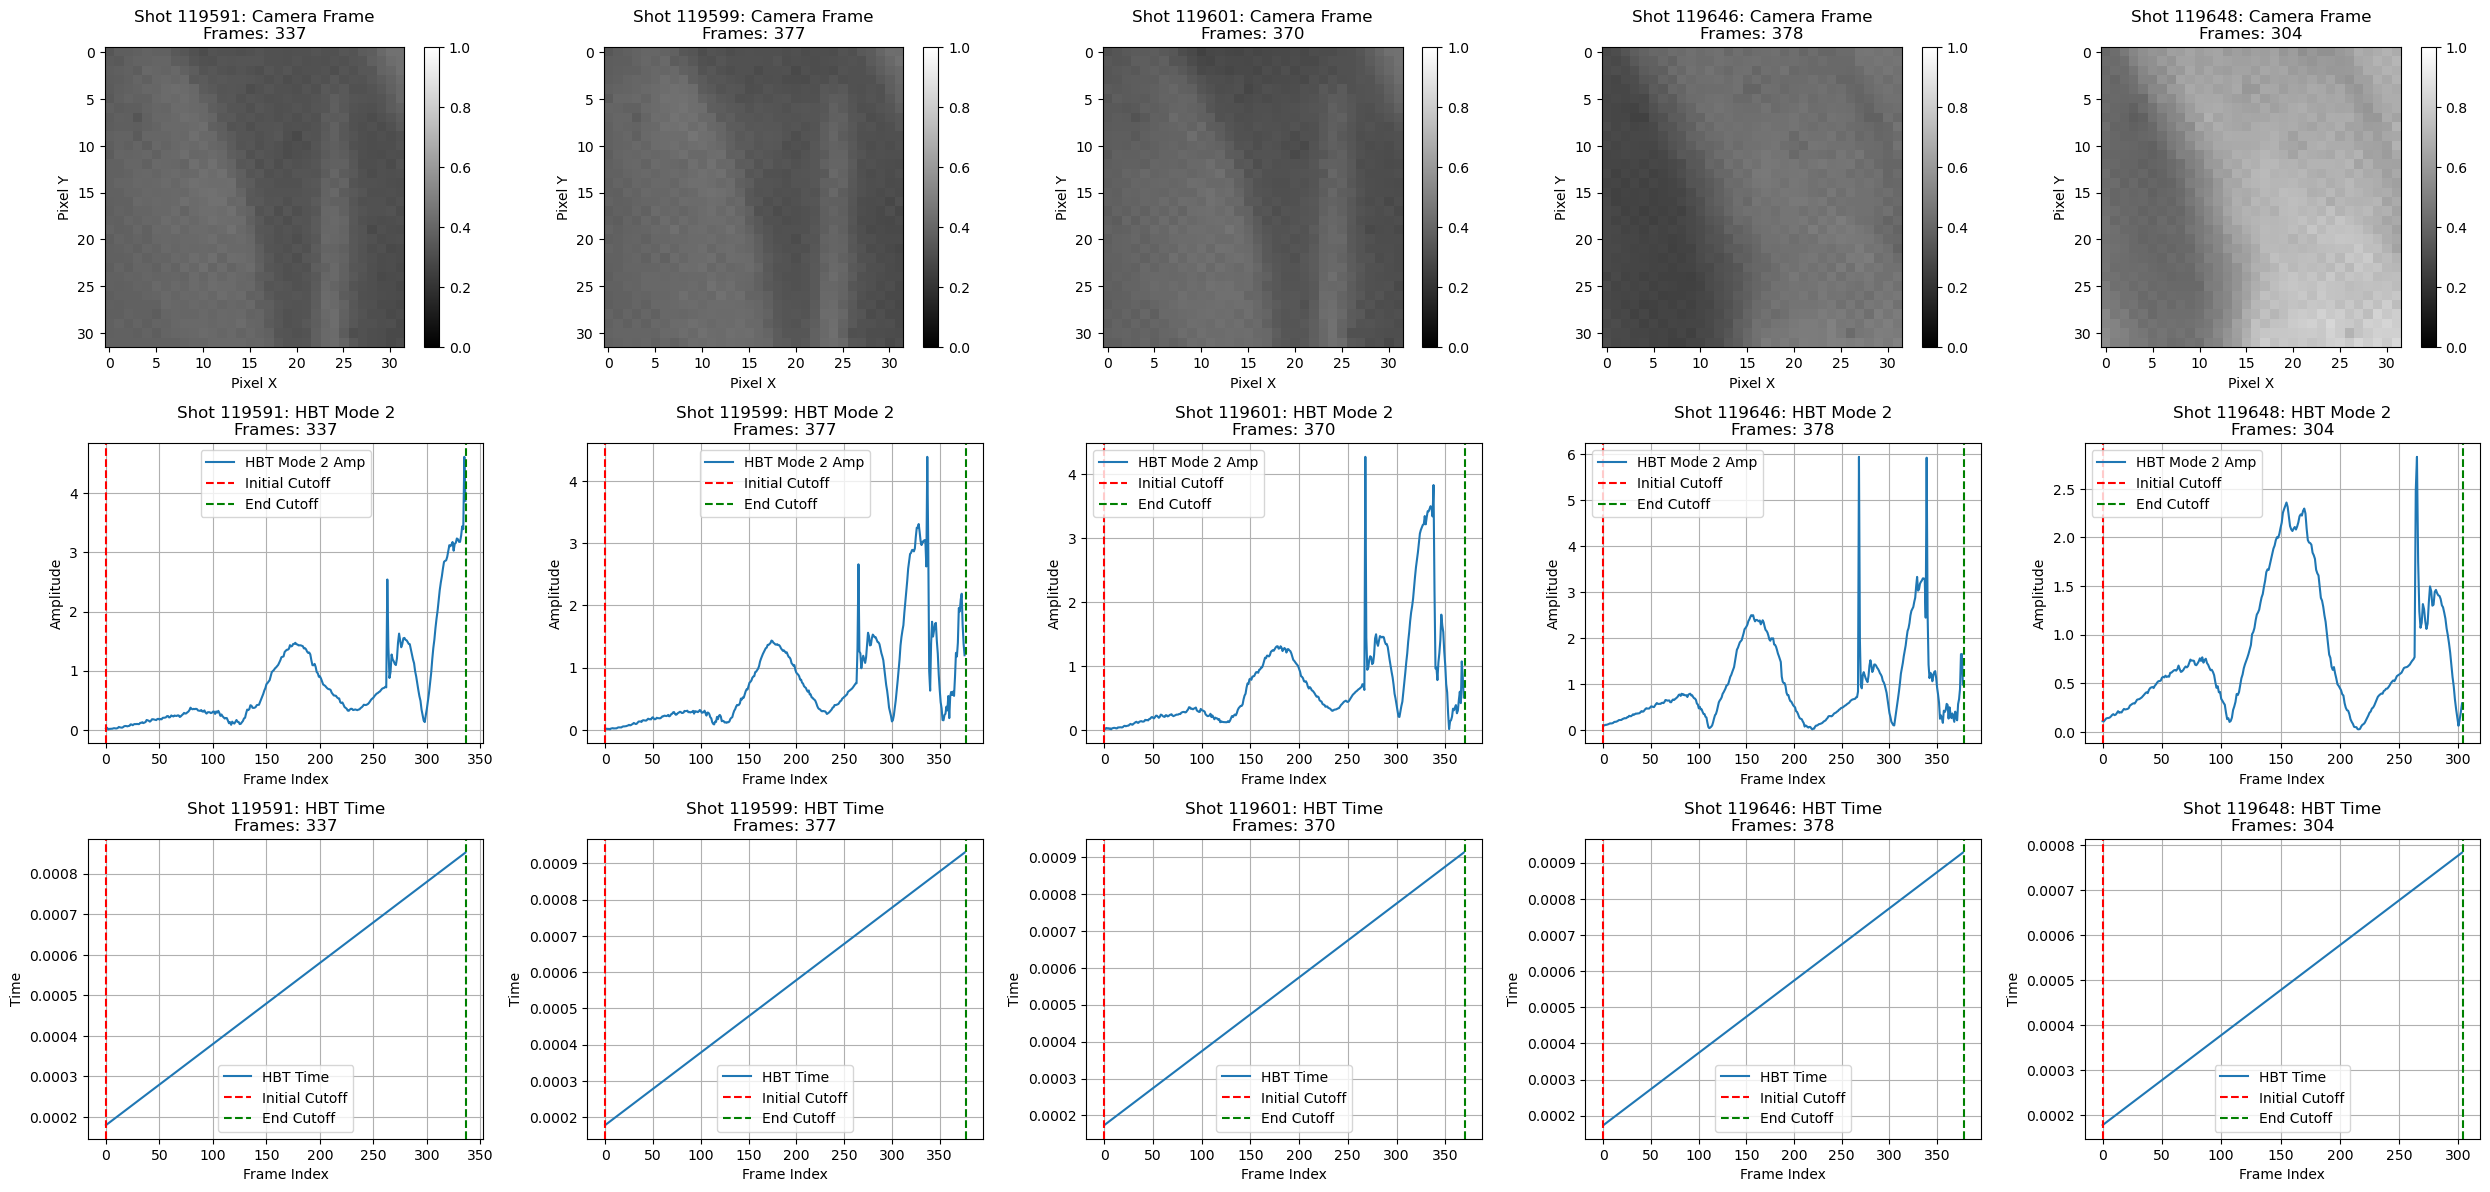

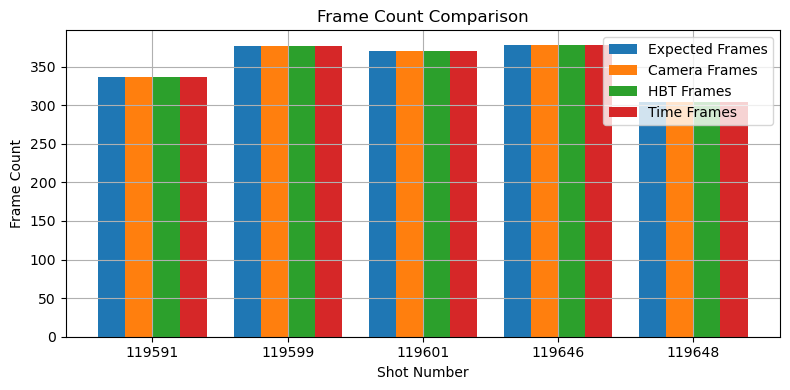

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_non_ip_data(shot_list, valid_shots, cut_training_data_2D, hbt_ma2_data, hbt_time_data, 
                          initial_cutoff_indices, end_cutoff_indices, actual_frame_counts, num_shots_to_plot):
    """
    Visualize camera, HBT mode amplitude, and time data with cutoff indices for debugging.
    
    Parameters:
    - shot_list: List of shot numbers
    - valid_shots: List of shots successfully processed
    - cut_training_data_2D: Trimmed camera data (list of numpy arrays)
    - hbt_ma2_data: Trimmed HBT mode 2 amplitude data (list of numpy arrays)
    - hbt_time_data: Trimmed HBT time data (list of numpy arrays)
    - initial_cutoff_indices: List of initial cutoff indices
    - end_cutoff_indices: List of end cutoff indices
    - actual_frame_counts: List of actual frame counts after processing
    - num_shots_to_plot: Number of shots to visualize (default: 3)
    """
    # Select a few shots to visualize
    shots_to_plot = valid_shots[:min(num_shots_to_plot, len(valid_shots))]
    
    # Create figure for camera, HBT, and time data
    fig, axes = plt.subplots(3, len(shots_to_plot), figsize=(5 * len(shots_to_plot), 12))
    if len(shots_to_plot) == 1:
        axes = np.array([axes]).T  # Ensure 2D indexing
    
    for col, shot in enumerate(shots_to_plot):
        shot_idx = shot_list.index(shot)
        initial_idx = initial_cutoff_indices[shot_idx]
        end_idx = end_cutoff_indices[shot_idx]
        frame_count = actual_frame_counts[valid_shots.index(shot)]
        
        # Plot 1: Camera data (sample frame)
        camera_data = cut_training_data_2D[valid_shots.index(shot)]
        if len(camera_data) > 0:
            sample_frame = camera_data[len(camera_data)//2]  # Middle frame
            im = axes[0, col].imshow(sample_frame, cmap='gray', vmin=0, vmax=1)
            plt.colorbar(im, ax=axes[0, col])
            axes[0, col].set_title(f'Shot {shot}: Camera Frame\nFrames: {len(camera_data)}')
            axes[0, col].set_xlabel('Pixel X')
            axes[0, col].set_ylabel('Pixel Y')
        else:
            axes[0, col].text(0.5, 0.5, 'No Camera Data', ha='center', va='center')
            axes[0, col].set_title(f'Shot {shot}: Camera Frame\nFrames: 0')
        
        # Plot 2: HBT Mode 2 Amplitude
        hbt_data = hbt_ma2_data[valid_shots.index(shot)][:, 0]
        axes[1, col].plot(hbt_data, label='HBT Mode 2 Amp')
        axes[1, col].axvline(x=0, color='r', linestyle='--', label='Initial Cutoff')
        axes[1, col].axvline(x=end_idx - initial_idx, color='g', linestyle='--', label='End Cutoff')
        axes[1, col].set_title(f'Shot {shot}: HBT Mode 2\nFrames: {len(hbt_data)}')
        axes[1, col].set_xlabel('Frame Index')
        axes[1, col].set_ylabel('Amplitude')
        axes[1, col].legend()
        axes[1, col].grid(True)
        
        # Plot 3: HBT Time Data
        time_data = hbt_time_data[valid_shots.index(shot)]
        axes[2, col].plot(time_data, label='HBT Time')
        axes[2, col].axvline(x=0, color='r', linestyle='--', label='Initial Cutoff')
        axes[2, col].axvline(x=end_idx - initial_idx, color='g', linestyle='--', label='End Cutoff')
        axes[2, col].set_title(f'Shot {shot}: HBT Time\nFrames: {len(time_data)}')
        axes[2, col].set_xlabel('Frame Index')
        axes[2, col].set_ylabel('Time')
        axes[2, col].legend()
        axes[2, col].grid(True)
    
    plt.tight_layout()
    
    # Summary plot: Frame counts across datasets
    plt.figure(figsize=(8, 4))
    shot_indices = [shot_list.index(shot) for shot in shots_to_plot]
    expected_frames = [end_cutoff_indices[i] - initial_cutoff_indices[i] for i in shot_indices]
    camera_frames = [len(cut_training_data_2D[valid_shots.index(shot)]) for shot in shots_to_plot]
    hbt_frames = [len(hbt_ma2_data[valid_shots.index(shot)]) for shot in shots_to_plot]
    time_frames = [len(hbt_time_data[valid_shots.index(shot)]) for shot in shots_to_plot]
    
    x = np.arange(len(shots_to_plot))
    width = 0.2
    plt.bar(x - 1.5 * width, expected_frames, width, label='Expected Frames')
    plt.bar(x - 0.5 * width, camera_frames, width, label='Camera Frames')
    plt.bar(x + 0.5 * width, hbt_frames, width, label='HBT Frames')
    plt.bar(x + 1.5 * width, time_frames, width, label='Time Frames')
    plt.xticks(x, shots_to_plot)
    plt.xlabel('Shot Number')
    plt.ylabel('Frame Count')
    plt.title('Frame Count Comparison')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()

# Call the visualization function
visualize_non_ip_data(shot_list, valid_shots, cut_training_data_2D, hbt_ma2_data, hbt_time_data, 
                      initial_cutoff_indices, end_cutoff_indices, actual_frame_counts, num_shots_to_plot=5)

In [9]:
# Define model architecture
num_conv2d_layers = 2
num_dense_layers = 1

conv2d_neurons = [16, 16]
conv2d_size = [(8, 8), (8, 8)]
dense_layer_neurons = [10]
max_pooling_size = (4, 4)
activation_func = 'relu'
loss_func = 'mean_squared_error'
optimizer_func = 'adam'

# Create the model
william_model = tf.keras.models.Sequential()

# Add input layer
william_model.add(tf.keras.layers.InputLayer(shape=(32, 32, 1)))

# Add Conv2D layers
for i in range(num_conv2d_layers):
    william_model.add(tf.keras.layers.Conv2D(conv2d_neurons[i], conv2d_size[i], 1, activation=activation_func))
    william_model.add(tf.keras.layers.MaxPooling2D(max_pooling_size, 1))

# Flatten the output
william_model.add(tf.keras.layers.Flatten())

# Add dense layers
for i in range(num_dense_layers):
    william_model.add(tf.keras.layers.Dense(dense_layer_neurons[i], activation=activation_func))

# Output layer
william_model.add(tf.keras.layers.Dense(1))

# Compile the model
william_model.compile(optimizer=optimizer_func, loss=loss_func)

# Display model summary
william_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 25, 16)     │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 15, 15, 16)     │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        23,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,501 (158.21 KB)

 Trainable params: 40,501 (158.21 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
Model = william_model
history = Model.fit(training_vector, target_vector,
                       epochs=15,
                       validation_split=0.2,
                       verbose=1,
                       callbacks=[early_stop])

Epoch 1/15
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0179 - val_loss: 0.0281
Epoch 2/15
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0158 - val_loss: 0.0280
Epoch 3/15
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0227 - val_loss: 0.0281
Epoch 4/15
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0172 - val_loss: 0.0281
Epoch 5/15
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0226 - val_loss: 0.0288
Epoch 6/15
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0158 - val_loss: 0.0275
Epoch 7/15
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0149 - val_loss: 0.0274
Epoch 8/15
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0233 - val_loss: 0.0273
Epoch 9/15
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0159 - val_loss: 0.0288
Epoch 10/15
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0211 - val_loss: 0.0277
Epoch 11/15
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0152 - val_loss: 0.0276
Epoch 12/15
1065/1065 ━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


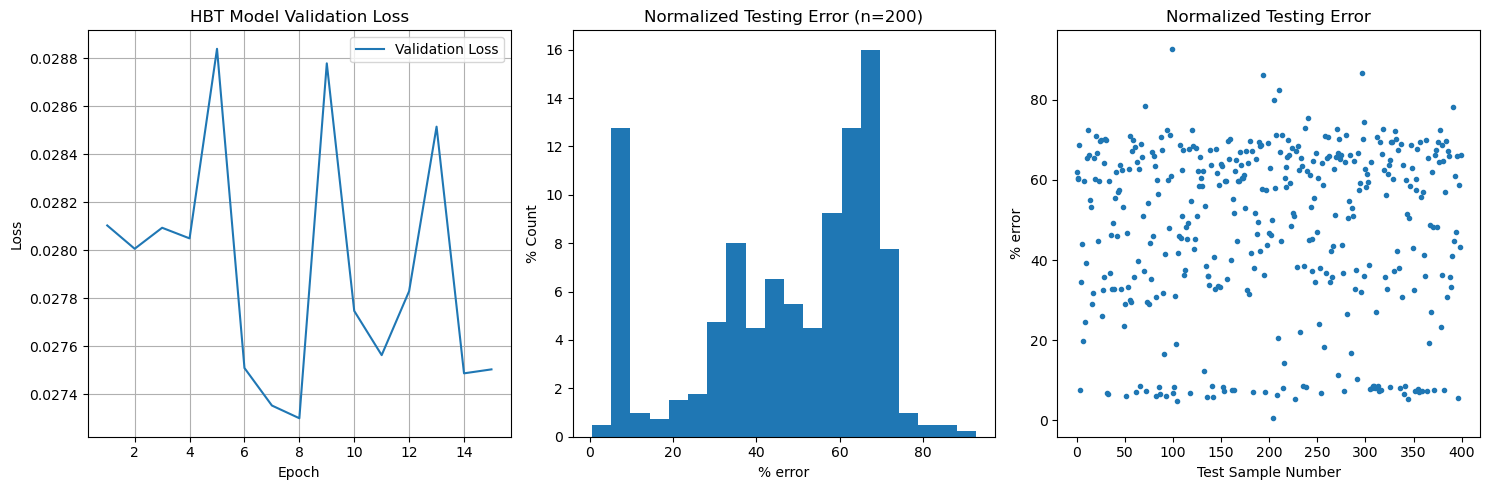

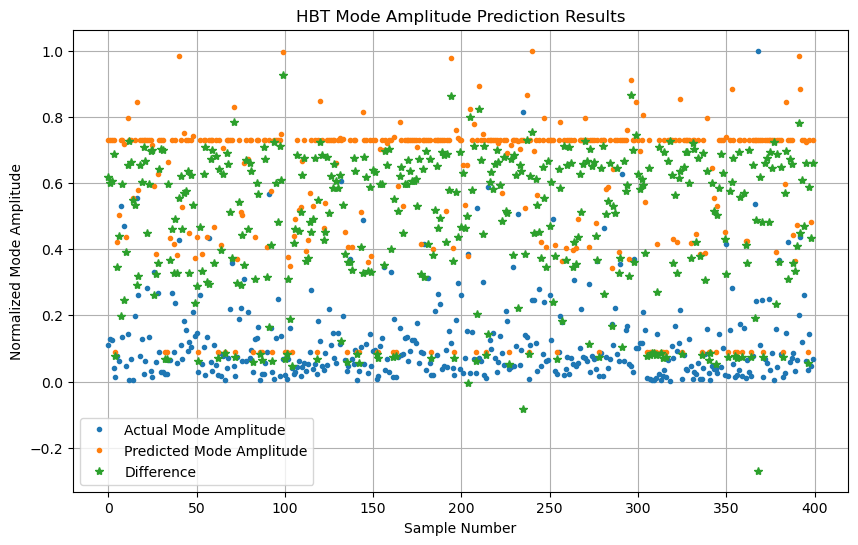

Maximum actual mode amplitude: 1.0545469522476196
Maximum predicted mode amplitude: 0.19358748197555542
Mean absolute percentage error: 47.58%


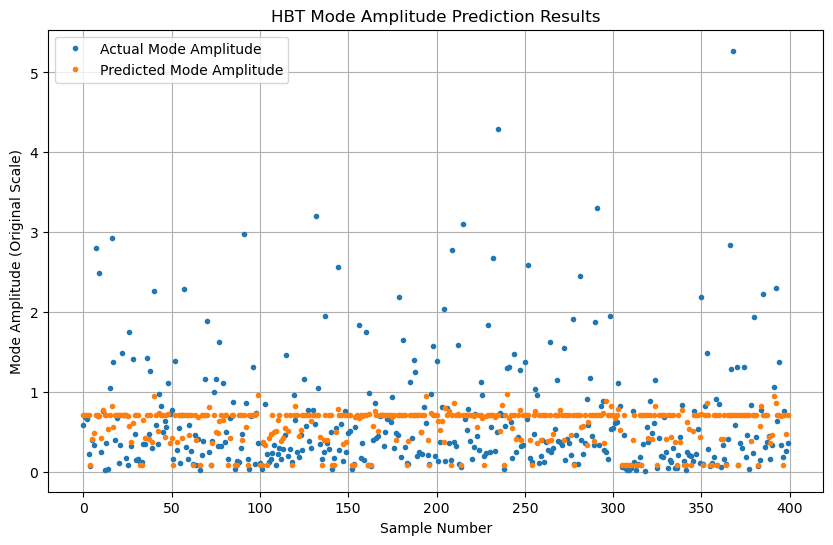

In [23]:
# Evaluate the model on test data
predictions = Model.predict(testing_inputs)

# Calculate prediction errors
prediction_errors = abs((testing_labels[:,0]/np.max(testing_labels[:,0]) - 
                        predictions[:,0]/np.max(predictions[:,0]))) * 100

# Create visualization plots
fig, axes = plt.subplots(figsize=(15,5), ncols=3, nrows=1)

# Plot 1: Training History
axes[0].plot(range(1,len(history.history['val_loss'])+1), 
             history.history['val_loss'], 
             label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('HBT Model Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Error Distribution
weights = np.ones_like(prediction_errors) / len(prediction_errors) * 100
axes[1].hist(prediction_errors, 20, weights=weights)
axes[1].set_xlabel('% error')
axes[1].set_ylabel('% Count')
axes[1].set_title('Normalized Testing Error (n=200)')

# Plot 3: Error by Sample
axes[2].plot(prediction_errors, '.')
axes[2].set_xlabel('Test Sample Number')
axes[2].set_ylabel('% error')
axes[2].set_title('Normalized Testing Error')

plt.tight_layout()
plt.show()

# Plot 4: actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(testing_labels[:,0]/np.max(testing_labels[:,0]), '.', label='Actual Mode Amplitude')
plt.plot(predictions[:,0]/np.max(predictions[:,0]), '.', label='Predicted Mode Amplitude')
plt.plot(-(testing_labels[:,0]/np.max(testing_labels[:,0]) - 
           predictions[:,0]/np.max(predictions[:,0])), '*', label='Difference')
plt.xlabel('Sample Number')
plt.ylabel('Normalized Mode Amplitude')
plt.title('HBT Mode Amplitude Prediction Results')
plt.legend()
plt.grid(True)
plt.show()

print(f"Maximum actual mode amplitude: {np.max(testing_labels[:,0])}")
print(f"Maximum predicted mode amplitude: {np.max(predictions[:,0])}")
print(f"Mean absolute percentage error: {np.mean(prediction_errors):.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(testing_labels * ma_norm, '.', label='Actual Mode Amplitude')
plt.plot(predictions * ma_norm, '.', label='Predicted Mode Amplitude')
plt.xlabel('Sample Number')
plt.ylabel('Mode Amplitude (Original Scale)')
plt.title('HBT Mode Amplitude Prediction Results')
plt.legend()
plt.grid(True)
plt.show()